# GeoPandas - Basics

`GeoPandas` is an open source project to make working with geospatial data in python easier. `GeoPandas` extends the datatypes used by `Pandas` to allow spatial operations on geometric types.

More infos on : https://geopandas.org/

In [1]:
import os
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
from pathlib import Path

from IPython.display import Image
from IPython.display import display

print(f'Pandas    : {pd.__version__}')
print(f'GeoPandas : {gpd.__version__}')

Pandas    : 1.1.5
GeoPandas : 0.9.0


## Set paths for input and output directories

Create directories if there are missing using `Path` and `mkdir`

In [2]:
grp_letter   = 'X'
student_name = 'ndeffense'

# When you are connected to the computer room

vector_path = 'X:/data/VECTOR/'
output_path = f'X:/GROUP_{grp_letter}/TP/{student_name}/DATA/'



print(f'Vector input path is set to : {vector_path}')
print(f'Output path is set to       : {output_path}')


# Directory to store ROI extent
roi_path = f'{output_path}ROI/'

# Directory to store In-Situ
in_situ_path = f'{output_path}IN_SITU/'


# Create directories if missing
Path(roi_path).mkdir(parents=True, exist_ok=True)
Path(in_situ_path).mkdir(parents=True, exist_ok=True)


Vector input path is set to : X:/data/VECTOR/
Output path is set to       : X:/GROUP_X/TP/ndeffense/DATA/


## Reading shapefile

With `GeoPandas` we can read a shapefile in a GeoDataFrame and apply many methods on it.
- **GeoSeries** : a vector where each entry in the vector is a set of shapes corresponding to one observation.
- **GeoDataFrame** : a tabular data structure that contains a GeoSeries column that holds a special status. This GeoSeries is referred to as the GeoDataFrame’s “geometry”. When a spatial method is applied to a GeoDataFrame (or a spatial attribute like 'area' is called), this commands will always act on the “geometry” column. A GeoDataFrame is equivalent to the Attribute Table in QGIS + a geometry column (which is hidden in QGIS).


`GeoPandas` has three basic classes of geometric objects (which are actually `shapely` objects):
- Points / Multi-Points
- Lines / Multi-Lines
- Polygons / Multi-Polygons

In [3]:
vector_name = 'WALLONIA_2018_Cropland.shp'

vector_file = f'{vector_path}{vector_name}'

print(f'Reading the vector file : {vector_file}')

# Read the file "vector_file" using GeoPandas (gpd) into the GeoDataFrame "gdf"
gdf = gpd.read_file(filename=vector_file)

# Display the 5 first rows of the GeoDataFrame
display(gdf.head())

# Get the Coordinates Reference System (CRS)
print(f'\n The Coordinates Reference System is {gdf.crs}')


Reading the vector file : X:/data/VECTOR/WALLONIA_2018_Cropland.shp


,ID,CROP,LC,CODE,IRRIGATION,geometry
0,1,1,Grassland (temporary),62,0,"POLYGON ((534958.317 5621580.609, 534963.783 5..."
1,2,1,Sugar beet,91,0,"POLYGON ((545783.879 5607562.806, 545784.147 5..."
2,3,1,Maize (for livestock),201,0,"POLYGON ((545590.560 5607777.241, 545619.713 5..."
3,4,1,Common wheat (winter),311,0,"POLYGON ((546029.943 5607654.334, 546025.553 5..."
4,5,1,Maize (for livestock),201,0,"POLYGON ((545993.255 5607595.831, 546028.753 5..."



 The Coordinates Reference System is epsg:32631


## Creating a new shapefile containing your Region of Interest (ROI)

We will create the shapefile of your ROI from a set of coordinates.

#### Choose the CRS of the new shapefile - crs_dst

It is important to set the EPSG code matching with the EPSG code of your satellite images!

For instance, if your ROI is located in Belgium,
- the CRS is WGS 84 / UTM zone 31N
- the EPSG code is 32631

#### Choose the CRS of the coordinates - crs_src

- Degree - WGS84 - EPSG:4326
- Meters - WGS 84 / UTM zone 31N - EPSG:32631 (RECOMMENDED)

#### Coordinates bounding box

Extent in QGIS --> ulx, uly : lrx, lry

- ulx = Upper Left x
- uly = Upper Left y
- lrx = Lower Right x
- lry = Lower Right y


<img src="figures/ROI_box.png" width="500">




In [4]:
# EPSG of your ROI
crs_dst = 'EPSG:32631'    # WGS 84 / UTM zone 31N

roi_name      = 'extent_roi'
roi_extension = '.shp'

roi_file = f'{roi_path}{roi_name}_{crs_dst[5:]}{roi_extension}'

# EPSG of your coordinates
crs_src = 'EPSG:32631'


# Set coordinates of your ROI - be carefull of the crs_src you chose!
ulx = 627263.7
uly = 5596175.1
lrx = 637115
lry = 5590485.2


# Create a list with the longitude coordinates (x)
lon_point_list = [ulx, lrx, lrx, ulx, ulx]


# Create a list with the latitude coordinates (y)
lat_point_list = [uly, uly, lry, lry, uly]


# Create a polygon object from the two list (lon and lat)
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))


# Create a GeoDataFrame with the polygon object
polygon_src = gpd.GeoDataFrame(index=[0], crs=crs_src, geometry=[polygon_geom])       


# Reproject the GeoDataFrame to the destination CRS (needed only if you set your coordinates in WGS 84)
polygon_dst = polygon_src.to_crs(crs_dst)

# Check CRS of your polygon
print(f'ROI CRS : {polygon_dst.crs} \n')

# Write the GeoDataFrame in a shapefile if not exists

if not os.path.isfile(roi_file):
    polygon_dst.to_file(filename=roi_file, driver='ESRI Shapefile')
    print(f'A new vector file is created : {roi_file}')
else:
    print('The ROI vector file already exists --> delete it or change the variable "roi_name" if you want to create a new one')


ROI CRS : EPSG:32631 

The ROI vector file already exists --> delete it or change the variable "roi_name" if you want to create a new one


## Manipulation on in-situ dataset

### Open in-situ datasets (Wallonia 2018) and ROI in *GeoDataFrame*

- Cropland - SIGEC dataset
- Non-cropland - homemade dataset
- Region of Intrest created previously

In [5]:
cropland_shp = f'{vector_path}WALLONIA_2018_Cropland.shp'
non_crop_shp = f'{vector_path}WALLONIA_2018_Non_cropland.shp'

cropland_gdf = gpd.read_file(cropland_shp)
non_crop_gdf = gpd.read_file(non_crop_shp)
roi_gdf      = gpd.read_file(roi_file)

### Select polygons within the ROI extent

1. Clip polygons with the ROI extent --> can potentially create "*multi-polygons*" geometries that will cause problems later on !
2. Select polygons within the ROI extent

**Warning** :

Both layers must be in the same Coordinate Reference System (CRS). The *gdf* will be clipped to the full extent of the clip object.

If there are multiple polygons in mask, data from *gdf* will be clipped to the total boundary of all polygons in mask.

In [6]:
# 1. Clip polygons to the ROI extent
# ----------------------------------

'''
non_crop_gdf = gpd.clip(non_crop_gdf, roi_gdf)
cropland_gdf = gpd.clip(cropland_gdf, roi_gdf)
'''

# 2. Select polygons within the ROI extent
# ----------------------------------------

# Get the geometry of the ROI

roi_geom = roi_gdf.geometry[0]

non_crop_gdf = non_crop_gdf[non_crop_gdf.within(roi_geom)]
cropland_gdf = cropland_gdf[cropland_gdf.within(roi_geom)]


### Merge both datasets into one

In [7]:
dataset_to_merge = [cropland_gdf, non_crop_gdf]

in_situ_gdf = pd.concat(dataset_to_merge, ignore_index=True)

### Write the new in-situ dataset into a shapefile

In [8]:
in_situ_file = f'{in_situ_path}WALLONIA_2018_IN_SITU_ROI.shp'

in_situ_gdf.to_file(in_situ_file)

display(in_situ_gdf)

,ID,CROP,LC,CODE,IRRIGATION,geometry
0,1877,1,Maize (for livestock),201,0,"POLYGON ((634719.076 5591248.019, 634788.109 5..."
1,1878,1,Common wheat (winter),311,0,"POLYGON ((634996.603 5591774.690, 635051.974 5..."
2,1879,1,Maize (for livestock),201,0,"POLYGON ((635196.857 5591331.590, 635199.724 5..."
3,1880,1,Grassland (temporary),62,0,"POLYGON ((635003.339 5591080.041, 635021.807 5..."
4,3251,1,Barley (winter),321,0,"POLYGON ((634708.850 5590509.262, 634710.400 5..."
...,...,...,...,...,...,...
325,183204,0,Not agriculture,20,0,"POLYGON Z ((634030.058 5595825.237 0.000, 6340..."
326,183206,0,Not agriculture,19,0,"POLYGON Z ((627815.480 5595734.706 0.000, 6278..."
327,183208,0,Not agriculture,19,0,"POLYGON Z ((628489.484 5595844.131 0.000, 6284..."
328,183210,0,Not agriculture,6,0,"POLYGON Z ((632038.546 5595956.541 0.000, 6320..."


## Plot vector data with `matplolib`

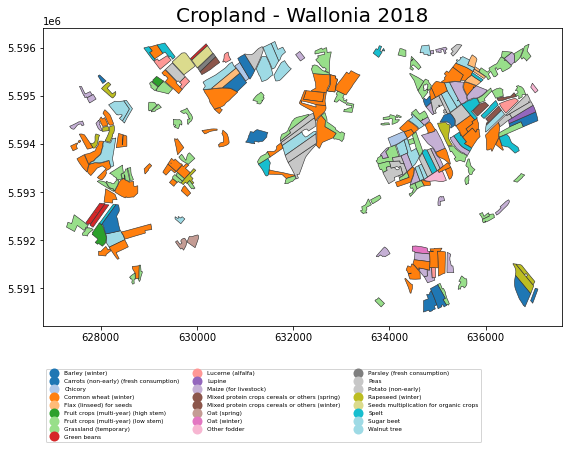

In [9]:
# Plot cropland from SIGEC
# ------------------------

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

cropland_gdf.plot(ax=ax, column='LC', categorical=True, cmap='tab20', linewidth=.6, edgecolor='0.2',
    legend=True, legend_kwds={'loc':'lower left','bbox_to_anchor':(0,-0.4), 'fontsize':'xx-small', 'ncol':3})

ax.set_title('Cropland - Wallonia 2018',fontsize=20)

plt.tight_layout()

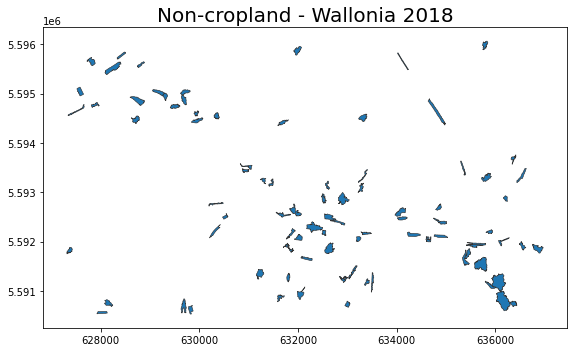

In [10]:
# Plot Non-croplands
# ------------------

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

non_crop_gdf.plot(ax=ax, column='LC', categorical=True, cmap='tab20', linewidth=.6, edgecolor='0.2')

ax.set_title('Non-cropland - Wallonia 2018',fontsize=20)

plt.tight_layout()

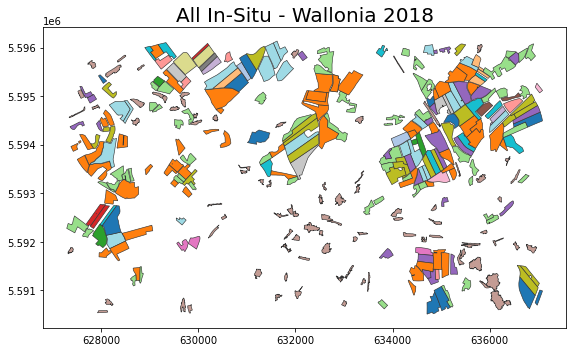

In [13]:
# Plot all in-situ
# ----------------

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

in_situ_gdf.plot(ax=ax, column='LC', categorical=True, cmap='tab20', linewidth=.6, edgecolor='0.2', legend=False)

ax.set_title('All In-Situ - Wallonia 2018',fontsize=20)

plt.tight_layout()